# Введение в Вариационные Автоэнкодеры (VAE) на PyTorch

*Проект выполнен студентом 331 группы Ряховским Алексеем*

Этот ноутбук представляет собой подробное введение в вариационные автоэнкодеры (VAE). Я расскажу теоретические основы, математику, реализуем VAE с использованием PyTorch и обучим его на классическом наборе данных MNIST (рукописные цифры).

**Цели:**
1.  Объяснить концепцию **стандартных автоэнкодеров (AE)** как основу.
2.  Подробно разобрать **теорию VAE**: зачем они нужны, как работают, их математические основы (ELBO, репараметризационный трюк, KL-дивергенция).
3.  Реализовать модель VAE на **PyTorch**.
4.  Обучить VAE на данных **MNIST**.
5.  Продемонстрировать возможности VAE: реконструкция, визуализация латентного пространства, генерация новых данных.

<img src="images/1.png" alt="Мое изображение" style="display: block; margin-left: auto; margin-right: auto; width: 600px;">

In [5]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

import warnings
warnings.filterwarnings("ignore")

# Для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)

# Создаем папку для сохранения результатов (сгенерированных картинок)
sample_dir = 'samples_vae'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## 1. Теория - От Автоэнкодеров (AE) к Вариационным Автоэнкодерам (VAE)

### Что такое Автоэнкодер (AE)?

Прежде чем погрузиться в VAE, давайте вспомним (или узнаем) про **стандартные (или базовые) автоэнкодеры (AE)**.

**Цель AE:** Научиться сжимать данные (например, изображение) в представление меньшей размерности (латентный код) и затем восстанавливать (реконструировать) исходные данные из этого сжатого представления с минимальными потерями.

**Структура AE:**
1.  **Энкодер (Encoder):** Нейронная сеть, которая принимает входные данные $x$ и преобразует их в латентный код $z$ ($z = \text{Encoder}(x)$). Обычно $z$ имеет гораздо меньшую размерность, чем $x$.
2.  **Латентное пространство (Latent Space):** Пространство, в котором существуют векторы $z$. Его размерность - это "узкое горлышко" (bottleneck) автоэнкодера.
3.  **Декодер (Decoder):** Нейронная сеть, которая принимает латентный код $z$ и пытается восстановить исходные данные $\hat{x}$ ($\hat{x} = \text{Decoder}(z)$).

**Обучение AE:**
Модель обучается минимизировать **ошибку реконструкции** - разницу между исходным входом $x$ и восстановленным выходом $\hat{x}$. В качестве функции потерь часто используют среднеквадратичную ошибку (Mean Squared Error, MSE) или бинарную кросс-энтропию (Binary Cross-Entropy, BCE).

Формула ошибки реконструкции для Среднеквадратичной Ошибки (MSE):

$$ \large L_{AE} = ||x - \hat{x}||^2$$

Формула ошибки реконструкции для Бинарной Кросс-Энтропии (BCE):

$$ \large L_{AE} = -\sum_{i} [x_i \log(\hat{x}_i) + (1-x_i) \log(1-\hat{x}_i)]$$

**Проблема AE для генерации:**
Хотя AE хороши для сжатия и извлечения признаков, они **плохо подходят для генерации новых данных**. Проблема в том, что латентное пространство $z$ у AE обычно не имеет "хорошей" структуры. Если мы возьмем случайную точку $z$ из латентного пространства и подадим ее в декодер, результат $\hat{x}$ скорее всего будет бессмысленным шумом. Латентное пространство может быть "разреженным", с "дырами", и модель не знает, как интерполировать между известными кодами $z$.

### Вариационный Автоэнкодер (VAE): Идея

VAE решает проблему генерации, делая автоэнкодер **вероятностным**.

**Ключевое отличие:** Вместо того, чтобы энкодер отображал вход $x$ в *одну* точку $z$ в латентном пространстве, VAE энкодер отображает $x$ в **параметры вероятностного распределения** в латентном пространстве. Обычно это многомерное Гауссово распределение (нормальное распределение), которое характеризуется двумя векторами:
* **Среднее (mean):** $\mu$
* **Логарифм вариации (log-variance):** $\log \sigma^2$ (используют логарифм для численной стабильности)

То есть, $\text{Encoder}(x) = (\mu, \log \sigma^2)$. Это распределение $q(z|x)$ - наша *аппроксимация* истинного, но неизвестного апостериорного распределения $p(z|x)$.

**Сэмплирование из латентного пространства:**
Чтобы получить конкретный латентный вектор $z$ для данного $x$, мы **сэмплируем** его из распределения $\mathcal{N}(\mu, \sigma^2)$, параметры которого выдал энкодер. $z \sim q(z|x) = \mathcal{N}(z | \mu, \sigma^2)$.

**Декодер VAE:**
Работает так же, как в AE: принимает латентный вектор $z$ и генерирует реконструированный выход $\hat{x}$. $\hat{x} = \text{Decoder}(z)$. Декодер определяет распределение $p(x|z)$.

### Репараметризационный Трюк (Reparameterization Trick)

Возникает проблема: процесс сэмплирования $z \sim \mathcal{N}(\mu, \sigma^2)$ является **стохастическим (случайным)**. Стандартные методы обратного распространения ошибки (backpropagation) не могут проходить через случайные узлы. Как же обучать энкодер, если градиент не может "добраться" до $\mu$ и $\log \sigma^2$?

На помощь приходит **репараметризационный трюк**. Идея в том, чтобы выразить случайный сэмпл $z$ как **детерминированную функцию** параметров распределения ($\mu, \sigma^2$) и **независимой случайной переменной** $\epsilon$, имеющей фиксированное распределение (обычно стандартное нормальное $\mathcal{N}(0, I)$).

Для Гауссова случая:
$z = \mu + \sigma \cdot \epsilon = \mu + \exp(0.5 \cdot \log \sigma^2) \cdot \epsilon$
где $\epsilon \sim \mathcal{N}(0, I)$.

Теперь случайность "вынесена" в $\epsilon$. Путь от $\mu$ и $\log \sigma^2$ к $z$ становится детерминированным и, следовательно, **дифференцируемым**. Градиенты могут спокойно проходить через эту операцию к параметрам энкодера.

<img src="images/2.png" alt="Схема Репараметризационного Трюка" style="display: block; margin-left: auto; margin-right: auto; width: 500px;">

### Функция Потерь VAE (ELBO)

Так как, VAE - это генеративная модель. В идеале, мы хотим максимизировать правдоподобие данных $p(x)$ по всем возможным латентным переменным $z$: $$ \large p(x) = \int p(x|z) p(z) dz$$ где $p(z)$ - это априорное распределение латентных переменных (обычно $\mathcal{N}(0, I)$), а $p(x|z)$ - правдоподобие данных при заданном $z$ (моделируется декодером). Этот интеграл обычно неразрешим аналитически.

VAE используют подход вариационного вывода. Вместо максимизации $p(x)$ напрямую, максимизируется его **нижняя оценка правдоподобия (Evidence Lower Bound, ELBO)**:
<br>$$\large \log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) || p(z))$$

<br>Максимизация ELBO эквивалентна минимизации **отрицательного ELBO**, которое и используется как функция потерь VAE:
<br>$$\large L_{VAE} = -\text{ELBO} = \underbrace{-\mathbb{E}_{q(z|x)}[\log p(x|z)]}_{\text{Ошибка Реконструкции}} + \underbrace{D_{KL}(q(z|x) || p(z))}_{\text{KL-дивергенция}}$$

Разберем компоненты:

1.  **Ошибка Реконструкции (Reconstruction Loss):** $ \large -\mathbb{E}_{q(z|x)}[\log p(x|z)]$
    * Это ожидаемое (среднее) отрицательное логарифмическое правдоподобие реконструкции. Оно измеряет, насколько хорошо декодер ($p(x|z)$) восстанавливает входные данные $x$ после того, как они были закодированы ($q(z|x)$) и сэмплированы ($z$).
    * На практике, для одного сэмпла $z$ из $q(z|x)$ для данного $x$, это просто $-\log p(x|z)$.
    * Если мы предполагаем, что пиксели изображения $x$ независимы и имеют распределение Бернулли (вероятность быть белым = $\hat{x}_i$), то этот член превращается в **Бинарную Кросс-Энтропию (BCE)** между $x$ и $\hat{x} = \text{Decoder}(z)$.
    * Если предположить Гауссово распределение $p(x|z)$, то получится **Среднеквадратичная Ошибка (MSE)**. Для MNIST с пикселями в [0, 1] обычно используют BCE.
    * Формула BCE: $ L_{recon} = -\sum_{i=1}^{D} [x_i \log(\hat{x}_i) + (1-x_i) \log(1-\hat{x}_i)]$, где $D$ - размерность $x$.<br>
    `
2.  **KL-дивергенция (Kullback–Leibler Divergence):** $\large D_{KL}(q(z|x) || p(z))$

    * Это мера "расстояния" или "различия" между распределением, которое выдает энкодер ($q(z|x) = \mathcal{N}(\mu, \sigma^2)$), и априорным распределением ($p(z) = \mathcal{N}(0, I)$).
    * Этот член действует как **регуляризатор**. Он заставляет энкодер генерировать распределения $q(z|x)$, близкие к стандартному нормальному. Это нужно для двух вещей:
        * **Организация латентного пространства:** Чтобы пространство было "заполнено" и точки для похожих $x$ были близки.
        * **Возможность генерации:** Чтобы мы могли сэмплировать $z$ напрямую из $p(z) = \mathcal{N}(0, I)$ и получать осмысленные результаты от декодера.
    * Для двух Гауссовых распределений $q(z|x) = \mathcal{N}(\mu, \sigma^2)$ и $p(z) = \mathcal{N}(0, I)$, <br> KL-дивергенция вычисляется аналитически:
        $$ \large D_{KL} = -0.5 \sum_{j=1}^{J} (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)$$
        где $J$ - размерность латентного пространства, $\mu_j$ и $\sigma_j^2$ - компоненты векторов $\mu$ и $\sigma^2$.

**Итог:** VAE обучается одновременно хорошо реконструировать данные и поддерживать структуру латентного пространства близкой к стандартному нормальному распределению. Это позволяет ему не только сжимать данные, но и генерировать новые.

## 2. Загрузка и подготовка данных MNIST (PyTorch)

Используем `torchvision` для загрузки MNIST. Применим преобразования:
1.  `ToTensor()`: Конвертирует NumPy массив (H x W x C) в `torch.FloatTensor` (C x H x W) и масштабирует значения пикселей в диапазон `[0.0, 1.0]`.
2.  `Flatten()`: Преобразует тензор изображения (1 x 28 x 28) в вектор (784). (Мы добавим это позже в модели или в цикле обучения).
Мы также создадим `DataLoader` для удобной работы с батчами.

In [8]:
# Параметры данных и обучения
batch_size = 128
image_size = 28*28 # 784
z_dim = 56          # Размерность латентного пространства 
learning_rate = 1e-3
image_channels = 1

# Загрузка MNIST
dataset = datasets.MNIST(root='data',
                         train=True,
                         transform=transforms.ToTensor(), # Преобразует в тензор и [0,1]
                         download=True)

data_loader = DataLoader(dataset=dataset,
                         batch_size=batch_size,
                         shuffle=True)

# Пример батча
# data_iter = iter(data_loader)
# images, labels = next(data_iter)
# print('Tensor shape:', images.shape) # torch.Size([128, 1, 28, 28])
# print('Min pixel value:', images.min())
# print('Max pixel value:', images.max())

# Определяем устройство (GPU если доступно, иначе CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Построение модели VAE (PyTorch)

Создадим класс `VAE`, наследуемый от `torch.nn.Module`. Он будет содержать:
* Энкодер: Несколько полносвязных слоев (`nn.Linear`) с ReLU активацией. Последний слой разделится на два для вывода $\mu$ и $\log \sigma^2$.
* Функцию репараметризации.
* Декодер: Несколько полносвязных слоев с ReLU, и последний слой с Sigmoid активацией, чтобы выходные пиксели были в диапазоне [0, 1].

In [26]:
#  Определение Модели ConvVAE 
class ConvVAE(nn.Module):
    def __init__(self, image_channels=1, z_dim=32):
        super(ConvVAE, self).__init__()
        self.z_dim = z_dim
        # Количество каналов после последнего сверточного слоя энкодера
        self.encoder_output_channels = 512
        # Размер выхода энкодера после Flatten (т.к. выход 1x1)
        self.encoder_output_flat_size = self.encoder_output_channels

        self.encoder = nn.Sequential(
            # Input: (N, 1, 28, 28)
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1), # -> (N, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> (N, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0), # K=3,S=2,P=0: 7 -> 3 -> (N, 256, 3, 3)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, self.encoder_output_channels, kernel_size=3, stride=1, padding=0), # K=3,S=1,P=0: 3 -> 1 -> (N, output_channels, 1, 1)
            nn.BatchNorm2d(self.encoder_output_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten() # -> (N, 512)
        )

        self.fc_mu = nn.Linear(self.encoder_output_flat_size, z_dim)
        self.fc_logvar = nn.Linear(self.encoder_output_flat_size, z_dim)
        self.decoder_fc = nn.Linear(z_dim, self.encoder_output_flat_size)

        self.decoder = nn.Sequential(
            # Reshape до (N, 512, 1, 1) происходит в методе decode
            nn.ConvTranspose2d(self.encoder_output_channels, 256, kernel_size=3, stride=1, padding=0), # K3,S1,P0: 1->3 -> (N, 256, 3, 3)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0, output_padding=1), # K3,S2,P0,OP1: 3->7 -> (N, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # K4,S2,P1: 7->14 -> (N, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=3), # K4,S2,P1: 14->28 -> (N, 1, 28, 28)
            nn.Sigmoid() # Выходные пиксели в [0, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, self.encoder_output_channels, 1, 1) # Reshape перед ConvTranspose2d
        x_reconstructed = self.decoder(h)
        return x_reconstructed

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

# Функция Потерь
def loss_function(recon_x, x, mu, log_var):
    # BCE требует выпрямленных входов одинакового размера
    BCE = F.binary_cross_entropy(recon_x.view(-1, 1*28*28),
                                 x.view(-1, 1*28*28),
                                 reduction='sum')
    # KL дивергенция
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


# Создание Модели и Оптимизатора
print("Создание модели и оптимизатора...")
model = ConvVAE(image_channels=image_channels, z_dim=z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("--- Структура Модели ---")
print(model)
print("------------------------")
print("Модель и оптимизатор созданы.")


Создание модели и оптимизатора...
--- Структура Модели ---
ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Line

## 4. Обучение модели VAE (PyTorch)

Теперь напишем цикл обучения. На каждой эпохе мы будем итерироваться по `DataLoader`, выполнять прямой проход, вычислять потери, выполнять обратное распространение ошибки и обновлять веса модели.

In [27]:
# Цикл обучения
num_epochs = 25

print(f"Запуск обучения на {num_epochs} эпох...")
model.train() # Переводим модель в режим обучения
total_steps = len(data_loader)

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for i, (x, _) in enumerate(data_loader):
        x = x.to(device) # Перемещаем на устройство, сохраняя форму (N, 1, 28, 28)

        # Прямой проход
        try:
            recon_x, mu, log_var = model(x)
        except Exception as e:
             print(f"\n!!! Ошибка во время прямого прохода: Эпоха {epoch+1}, Шаг {i+1} !!!")
             print(f"    Форма входа x: {x.shape}")
             print(f"    Тип объекта model: {type(model)}")
             print(f"    Сообщение об ошибке: {e}")
             raise e # Перевыбрасываем ошибку для полного traceback

        # Расчет потерь с помощью функции
        loss = loss_function(recon_x, x, mu, log_var)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Накопление общей потери для статистики эпохи
        epoch_loss += loss.item()
        # Для точного разделения потерь на Recon/KL потребовались бы метрики или отдельный расчет

        # Логирование каждые N шагов
        if (i + 1) % 100 == 0:
             # Выводим общую потерю на батч (усредненную по размеру батча)
            current_loss_per_item = loss.item() / x.size(0)
            print(f'Эпоха [{epoch+1}/{num_epochs}], Шаг [{i+1}/{total_steps}], Потеря: {current_loss_per_item:.4f}')

    # Логирование в конце эпохи
    # Убедимся, что dataset загружен
    if 'dataset' in locals() and dataset is not None and len(dataset) > 0:
        avg_epoch_loss = epoch_loss / len(dataset)
        print(f'====> Эпоха: {epoch+1} Средняя потеря: {avg_epoch_loss:.4f}')
    else:
        print(f'====> Эпоха: {epoch+1} Суммарная потеря: {epoch_loss:.4f} (не удалось рассчитать среднюю)')


    # Опционально: Сохранение примеров каждые N эпох
    if (epoch + 1) % 5 == 0: # Пример: сохраняем каждые 5 эпох
        print(f"Сохранение примеров для эпохи {epoch+1}...")
        model.eval() # Режим оценки
        with torch.no_grad():
            # Пример реконструкции (используем последний батч x и recon_x)
            if 'x' in locals() and 'recon_x' in locals():
                try:
                    n_examples = 8
                    orig_imgs = x[:n_examples].cpu()
                    recon_imgs = recon_x[:n_examples].cpu()
                    comparison = torch.cat([orig_imgs, recon_imgs], dim=0)
                    grid = make_grid(comparison, nrow=n_examples)
                    save_image(grid, os.path.join(sample_dir, f'reconstruction_epoch_{epoch+1}.png'))
                    print(f"Сохранены примеры реконструкции.")
                except Exception as e:
                    print(f"Ошибка при сохранении реконструкции: {e}")

            # Пример генерации
            try:
                z_sample = torch.randn(64, z_dim).to(device) # Генерируем 64 примера
                generated_imgs = model.decode(z_sample).cpu()
                grid = make_grid(generated_imgs.view(64, 1, 28, 28), nrow=8)
                save_image(grid, os.path.join(sample_dir, f'sample_epoch_{epoch+1}.png'))
                print(f"Сохранены сгенерированные примеры.")
            except Exception as e:
                 print(f"Ошибка при генерации/сохранении примеров: {e}")

        model.train() # Возвращаем режим обучения

print("\nОбучение завершено!")

Запуск обучения на 25 эпох...
Эпоха [1/25], Шаг [100/469], Потеря: 136.1427
Эпоха [1/25], Шаг [200/469], Потеря: 118.4309
Эпоха [1/25], Шаг [300/469], Потеря: 112.6411
Эпоха [1/25], Шаг [400/469], Потеря: 111.8181
====> Эпоха: 1 Средняя потеря: 132.9386
Эпоха [2/25], Шаг [100/469], Потеря: 112.8600
Эпоха [2/25], Шаг [200/469], Потеря: 109.0790
Эпоха [2/25], Шаг [300/469], Потеря: 106.4518
Эпоха [2/25], Шаг [400/469], Потеря: 109.9538
====> Эпоха: 2 Средняя потеря: 108.9775
Эпоха [3/25], Шаг [100/469], Потеря: 108.3000
Эпоха [3/25], Шаг [200/469], Потеря: 106.1323
Эпоха [3/25], Шаг [300/469], Потеря: 106.6198
Эпоха [3/25], Шаг [400/469], Потеря: 113.0718
====> Эпоха: 3 Средняя потеря: 106.3076
Эпоха [4/25], Шаг [100/469], Потеря: 103.7261
Эпоха [4/25], Шаг [200/469], Потеря: 104.7148
Эпоха [4/25], Шаг [300/469], Потеря: 103.8669
Эпоха [4/25], Шаг [400/469], Потеря: 103.6687
====> Эпоха: 4 Средняя потеря: 104.7712
Эпоха [5/25], Шаг [100/469], Потеря: 103.0031
Эпоха [5/25], Шаг [200/469],

## 5. Демонстрация возможностей VAE (после обучения)

Теперь, когда модель обучена, давайте еще раз посмотрим на результаты реконструкции и генерации, а также (если `z_dim = 2`) визуализируем латентное пространство.

### 5.1 Реконструкция изображений (Тестовый набор)

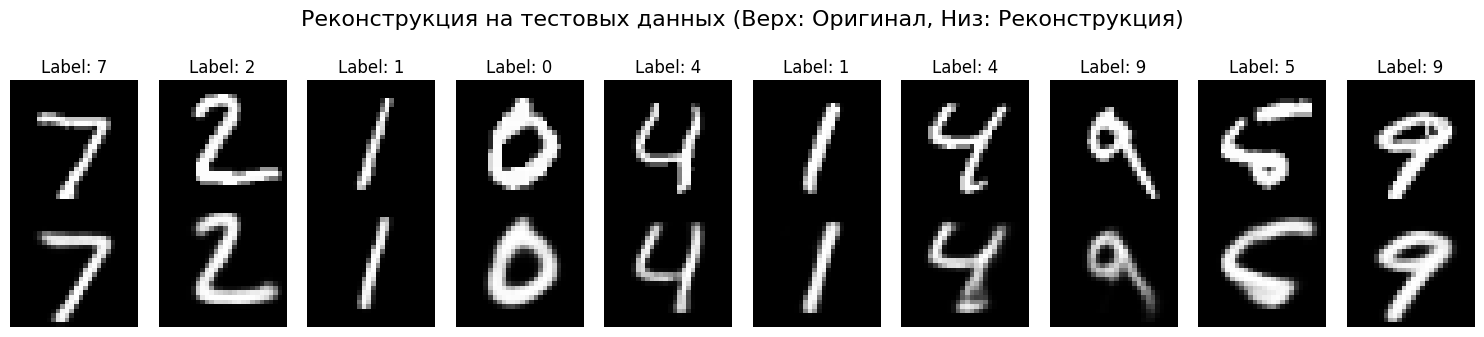

In [28]:
# Загрузим тестовый набор данных
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Возьмем один батч из тестового набора
model.eval() # Режим оценки
with torch.no_grad():
    test_iter = iter(test_loader)
    x_test, y_test = next(test_iter) # Получаем батч изображений и меток

    # ПРАВИЛЬНО для ConvVAE:
    # Перемещаем на устройство, СОХРАНЯЯ 4D форму (N, 1, 28, 28)
    x_test_on_device = x_test.to(device)

    # Получаем реконструкции, подавая 4D тензор в модель
    recon_test, _, _ = model(x_test_on_device) # mu, log_var нам здесь не нужны

    # --- Визуализация (этот код скорее всего уже правильный) ---
    n_examples = 10
    # Оригиналы берем из исходного x_test (на CPU)
    originals = x_test[:n_examples].view(-1, 1, 28, 28)
    # Реконструкции переносим на CPU для визуализации
    recons = recon_test[:n_examples].view(-1, 1, 28, 28).cpu()

    fig, axes = plt.subplots(2, n_examples, figsize=(15, 3.5))
    fig.suptitle("Реконструкция на тестовых данных (Верх: Оригинал, Низ: Реконструкция)", fontsize=16)
    for i in range(n_examples):
        # Оригинал
        axes[0, i].imshow(originals[i, 0].numpy(), cmap='gray')
        axes[0, i].set_title(f"Label: {y_test[i].item()}")
        axes[0, i].axis('off')
        # Реконструкция
        axes[1, i].imshow(recons[i, 0].numpy(), cmap='gray')
        axes[1, i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 5.2 Визуализация латентного пространства

In [ ]:
model.eval() # Переводим модель в режим оценки
latent_means = []
labels = []
n_samples_for_viz = 5000 # Ограничим кол-во точек для ускорения t-SNE

with torch.no_grad(): # Отключаем расчет градиентов
    # Прогоним часть тестового набора (или весь) через энкодер
    count = 0
    for i, (x, y) in enumerate(test_loader): # Используем test_loader, созданный ранее
        if count >= n_samples_for_viz:
            break
        x = x.to(device) # Форма (N, 1, 28, 28)
        mu, _ = model.encode(x) # Нам нужен только mu, форма (N, z_dim)
        latent_means.append(mu.cpu().numpy())
        labels.append(y.numpy())
        count += x.size(0)

latent_means = np.concatenate(latent_means, axis=0)
labels = np.concatenate(labels, axis=0)

# Убедимся, что взяли не больше n_samples_for_viz
latent_means = latent_means[:n_samples_for_viz]
labels = labels[:n_samples_for_viz]

# Инициализируем и применяем t-SNE
# n_components=2: Снижаем до 2 измерений для визуализации
# random_state: Для воспроизводимости.
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(latent_means)

# Создаем 2D график результатов t-SNE
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, label='Цифра')
plt.xlabel("t-SNE измерение 1")
plt.ylabel("t-SNE измерение 2")
plt.title(f"Визуализация латентного пространства MNIST (z_dim={z_dim}) с помощью t-SNE")
plt.grid(True)
plt.show()

### 5.3 Генерация новых изображений

Сэмплируем случайные векторы $z$ из априорного распределения $\mathcal{N}(0, I)$ и подаем их на вход декодеру для генерации новых цифр.

In [ ]:
n_generated_rows = 8
n_generated_cols = 8
n_generated_total = n_generated_rows * n_generated_cols # Сгенерируем 64 примера

print(f"Генерация {n_generated_total} новых изображений...")

model.eval()
with torch.no_grad(): # Отключаем расчет градиентов
    # Сэмплируем z из стандартного нормального распределения
    z_sample = torch.randn(n_generated_total, z_dim).to(device) # z_dim должен быть определен ранее
    # Декодируем в изображения
    generated_images = model.decode(z_sample).cpu() # Переносим на CPU для визуализации

fig, axes = plt.subplots(n_generated_rows, n_generated_cols, figsize=(12, 12)) # Создаем сетку для графиков
fig.suptitle("Сгенерированные изображения (из случайных z)", fontsize=16)

for i, ax in enumerate(axes.flat): # Итерируем по всем ячейкам сетки
    if i < n_generated_total:
        # Отображаем i-е сгенерированное изображение
        # .squeeze() убирает измерение канала (1) для отображения ЧБ картинки
        img = generated_images[i].squeeze()
        ax.imshow(img.numpy(), cmap='gray')
        ax.set_title(f"Generated {i+1}", fontsize=8) # Добавляем подпись к каждому
    ax.axis('off') # Отключаем оси координат

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Корректируем расположение для заголовка

plt.show()

Saved final generated samples grid.


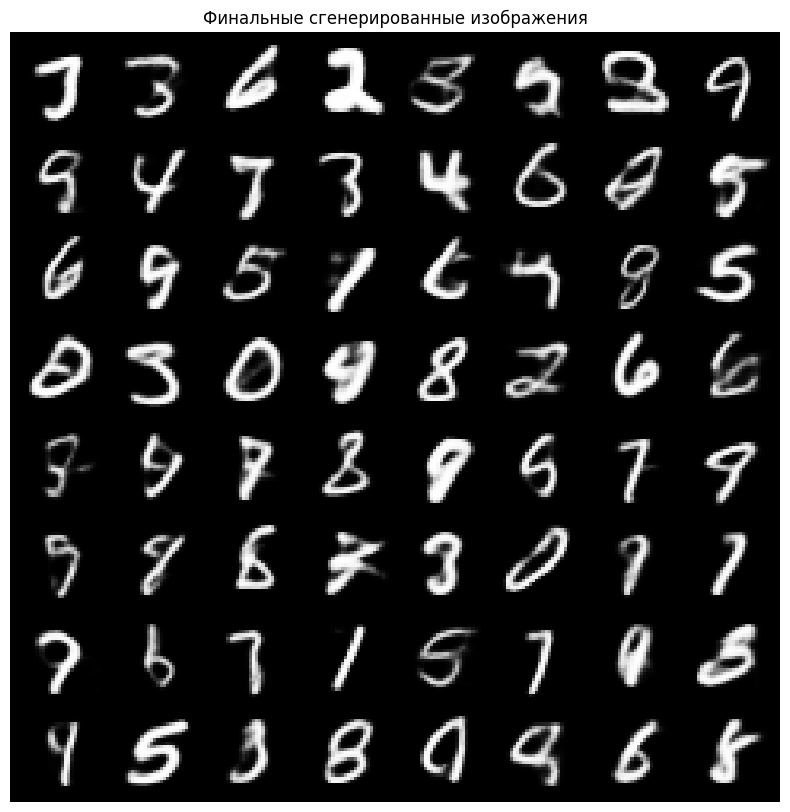

In [10]:
# Генерация новых цифр
model.eval()
with torch.no_grad():
    # Сэмплируем z из стандартного нормального распределения
    z_sample = torch.randn(64, z_dim).to(device) # Сгенерируем 64 примера
    # Декодируем в изображения
    generated_images = model.decode(z_sample).cpu()

    # Отображаем и сохраняем
    grid_final = make_grid(generated_images.view(64, 1, 28, 28), nrow=8)
    save_image(grid_final, os.path.join(sample_dir, 'final_generated_samples.png'))
    print("Saved final generated samples grid.")

    # Показываем в ноутбуке
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_final.permute(1, 2, 0)) # Меняем оси для Matplotlib (C, H, W) -> (H, W, C)
    plt.title("Финальные сгенерированные изображения")
    plt.axis('off')
    plt.show()

# Дополнительно: Manifold plot (если z_dim = 2)
if z_dim == 2:
    print("Генерация многообразия (manifold plot) для 2D латентного пространства...")
    n_manifold = 15  # Сетка 15x15
    figure = np.zeros((28 * n_manifold, 28 * n_manifold))
    
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n_manifold))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n_manifold)) # Используем те же значения для оси Y

    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                x_decoded = model.decode(z_sample).cpu()
                digit = x_decoded[0].view(28, 28).numpy()
                figure[i * 28: (i + 1) * 28,
                       j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(10, 10))
    # Отображаем инвертированно по Y для стандартного вида manifold plot
    plt.imshow(figure, cmap='gray', extent=[grid_x.min(), grid_x.max(), grid_y.max(), grid_y.min()])
    plt.title("Многообразие MNIST в 2D латентном пространстве VAE")
    plt.xlabel("Латентное измерение 1 ($z_1$)")
    plt.ylabel("Латентное измерение 2 ($z_2$)")
    plt.show()
    plt.savefig(os.path.join(sample_dir, 'manifold_plot_2d.png'))
    print("Saved manifold plot.")

Подготовка данных для поиска средних латентных распределений...
Собрано 10000 латентных представлений (mu и log_var).


Введите цифру от 0 до 9 для генерации (или 'q' для выхода):  0


Генерация варианта цифры 0 из усредненного распределения...


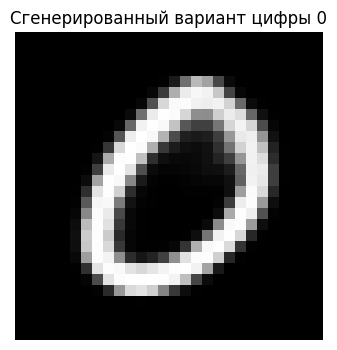

Введите цифру от 0 до 9 для генерации (или 'q' для выхода):  0


Генерация варианта цифры 0 из усредненного распределения...


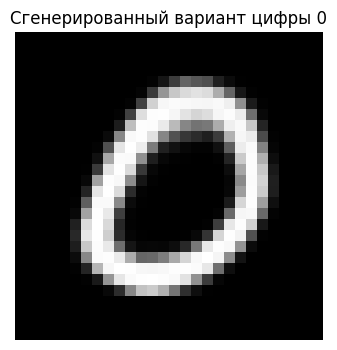

Введите цифру от 0 до 9 для генерации (или 'q' для выхода):  1


Генерация варианта цифры 1 из усредненного распределения...


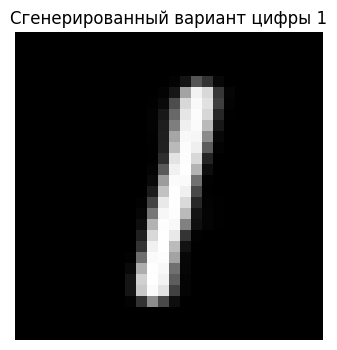

Введите цифру от 0 до 9 для генерации (или 'q' для выхода):  1


Генерация варианта цифры 1 из усредненного распределения...


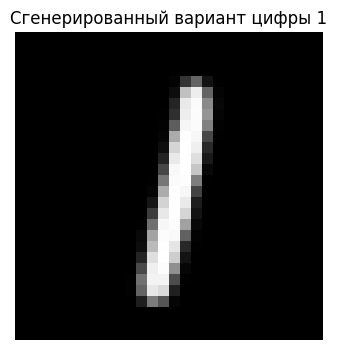

Введите цифру от 0 до 9 для генерации (или 'q' для выхода):  2


Генерация варианта цифры 2 из усредненного распределения...


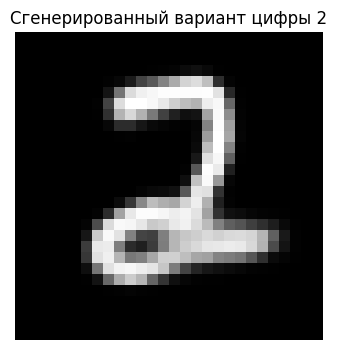

Введите цифру от 0 до 9 для генерации (или 'q' для выхода):  2


Генерация варианта цифры 2 из усредненного распределения...


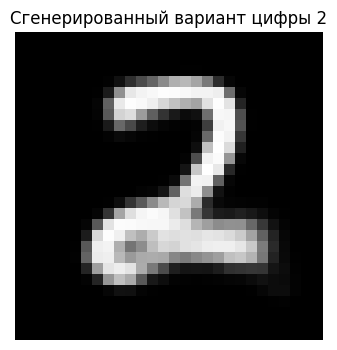

Введите цифру от 0 до 9 для генерации (или 'q' для выхода):  q


Выход.


In [11]:
model.eval()
all_mus = []
all_log_vars = [] 
all_labels = []

with torch.no_grad(): 
    # Пройдем по данным, чтобы собрать mu, log_var и метки
    for x, y in test_loader:
        x = x.to(device) # Форма (N, 1, 28, 28)
        mu, log_var = model.encode(x) # Получаем и mu, и log_var
        all_mus.append(mu.cpu())
        all_log_vars.append(log_var.cpu()) # Сохраняем log_var
        all_labels.append(y)

# Объединяем результаты из всех батчей
all_mus = torch.cat(all_mus, dim=0)
all_log_vars = torch.cat(all_log_vars, dim=0) # Объединяем log_var
all_labels = torch.cat(all_labels, dim=0)

print(f"Собрано {all_mus.shape[0]} латентных представлений (mu и log_var).")

while True:
    try:
        digit_str = input(f"Введите цифру от 0 до 9 для генерации (или 'q' для выхода): ")
        if digit_str.lower() == 'q':
            print("Выход.")
            break

        target_digit = int(digit_str)
        if 0 <= target_digit <= 9:
            # --- Поиск и усреднение mu и log_var для нужной цифры ---
            # Находим индексы, где метка совпадает с введенной цифрой
            indices = (all_labels == target_digit).nonzero(as_tuple=True)[0]

            if len(indices) == 0:
                print(f"Не найдено примеров для цифры {target_digit} в использованном наборе данных.")
                continue

            # Выбираем соответствующие векторы mu и log_var
            digit_mus = all_mus[indices]
            digit_log_vars = all_log_vars[indices]

            # Считаем средние значения
            mean_mu = torch.mean(digit_mus, dim=0)
            mean_log_var = torch.mean(digit_log_vars, dim=0)

            # --- Сэмплирование z из усредненного распределения ---
            print(f"Генерация варианта цифры {target_digit} из усредненного распределения...")
            with torch.no_grad():
                # Применяем репараметризационный трюк к средним mu и log_var
                std = torch.exp(0.5 * mean_log_var)
                # Генерируем случайный шум epsilon нужного размера (размер z_dim)
                eps = torch.randn_like(std) # Используем randn_like(std), чтобы размер совпадал
                # Вычисляем сэмплированный z
                z_sampled = mean_mu + eps * std

                # Перемещаем z на нужное устройство и добавляем размерность батча (1)
                z_sampled = z_sampled.unsqueeze(0).to(device)

                # Декодируем сэмплированный z
                generated_image = model.decode(z_sampled).cpu()

            # --- Отображение результата ---
            plt.figure(figsize=(4, 4))
            plt.imshow(generated_image.squeeze().numpy(), cmap='gray')
            plt.title(f"Сгенерированный вариант цифры {target_digit}")
            plt.axis('off')
            plt.show()

        else:
            print("Ошибка: Введите число от 0 до 9.")
    except ValueError:
        print("Ошибка: Введите число от 0 до 9.")
    except Exception as e:
        print(f"Произошла ошибка: {e}")
        break

In [22]:
import PIL

In [160]:
r = PIL.Image.open("C://Users//qw4rd//Downloads//Statprac//images//моя7ка.jpg")
r = np.array(r.convert(mode="L")).reshape(28,28,1) / 255

ValueError: cannot reshape array of size 756 into shape (28,28,1)

In [161]:
q = model(torch.tensor(1 - r, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to('cuda'))[0].reshape(28, 28, 1)
plt.imshow(q.cpu().detach(), cmap='gray')

TypeError: unsupported operand type(s) for -: 'int' and 'JpegImageFile'

## 6. Заключение

Я подробно рассмотрел теорию вариационных автоэнкодеров, начиная с основ обычных автоэнкодеров. Разобрал ключевые компоненты VAE: вероятностный энкодер, репараметризационный трюк, декодер и функцию потерь ELBO (ошибка реконструкции + KL-дивергенция).

Был реализован VAE с использованием PyTorch, обучил его на данных MNIST и продемонстрировал его основные возможности:
* **Реконструкция:** Способность восстанавливать входные изображения.
* **Структурированное латентное пространство:** (Визуализация показала кластеризацию цифр). KL-дивергенция помогла организовать это пространство.
* **Генерация:** Способность создавать новые, правдоподобные изображения путем сэмплирования из латентного пространства.

VAE - мощный инструмент в области генеративного моделирования и обучения представлений.